NecstProject NL1 Morcavallo Pietro:

Implementing a UNet for kidney tumor segmentation.


Downloading all dataset from the official github of kits19

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!git clone https://github.com/neheller/kits19

Cloning into 'kits19'...
remote: Enumerating objects: 1023, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1023 (delta 6), reused 16 (delta 4), pack-reused 1003
Receiving objects: 100% (1023/1023), 29.74 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (467/467), done.
Checking out files: 100% (223/223), done.


In [ ]:
cd kits19

/content/drive/MyDrive/Colab Notebooks/kits19


In [ ]:
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python3 -m starter_code.get_imaging


/usr/bin/python3: Error while finding module specification for 'starter_code.get_imaging' (ModuleNotFoundError: No module named 'starter_code')


Now, i will convert dataset from NIFTI to numpy format, in order to create the input for the UNET neural network.

According to **conversion.py** 


In [ ]:
!pip install pathlib2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Inspired by DigitalSreeni YTChannel in Image Segmentation using U-Net
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib2 import Path
from keras.utils import array_to_img as array_to_img
from skimage.transform import resize

#  uniformo il datasert con la funzione normalize a 512x512
def _normalize(vol):
    hu_max = 256 
    hu_min = -256
    vol = np.clip(vol, hu_min, hu_max)

    mxval = np.max(vol)
    mnval = np.min(vol)
    volume_norm = (vol - mnval) / max(mxval - mnval, 1e-3)

    return volume_norm


def _conversion_nii_to_data_array(path: Path):
    """
    Il path dovrà avere come terminazione un .nii.gz e restiturà l'array per keras

    :param path:
    :return: keras image obj
    """

    ct_Img = nib.load(path)
    ct_Img = ct_Img.get_fdata()
    ct_Img = _normalize(ct_Img)

    return ct_Img


def keras_array_of_cases(flag: int, start: int, end: int):
    """
    Questa funzione restituisce una lista np array che contiene tutti i cases (a loro volta keras img obj) , scelti da start a end
    Inizialmente entra nella directory e crea un primo array con il caso start , ne fa l'append e ripete per tutti i case fino a end


    :param flag: se 1 solo converte imaging, se 0 converte segmentation
    :param start: un int che indica da quale caso partire per il .append della lista
    :param end:(come start) dove arriva
    :return: np array finale
    """

    # inizializzo rispetto alla struttura del Dataset di kits19, all'interno del mio Drive
    PACKAGE_LOCATION = Path(os.path.abspath( 'drive/MyDrive/Colab Notebooks/kits19'))
    DATA_LOCATION = PACKAGE_LOCATION / "data"

    type = 'imaging'
    if flag == 0:
        type = 'segmentation'
    else:
        type = 'imaging'

    cases = []
    for out in range(start, end):
        # costituisco un array di un array
        print('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
        print('Loading and normalizing case_' + f'{out:05}' + ' case...')

        temp_path = DATA_LOCATION / f'case_{out:05}' / (str(type) + '.nii.gz')


        #case corrisponde al numpy array di un solo case
        case =  _conversion_nii_to_data_array(temp_path)

        slice_factor = 15/100  #ex: su 100 slice  ne prendo 15

        passo = int(case.shape[0] * slice_factor)

        #per le ct con poche slice --> prendo tutte le slice : passo=1
        if passo==0:
          passo = 1

        print( 'Slice totali: ' + str(int(case.shape[0])) )


        #Inserisco una slice alla volta, cercando di prenderle in modo uniforme
        for j in range(0, int(case.shape[0])  ,passo):

          print("Caso : "+ str(out) +" slice scelta num: "+ str(j) + " su slice totali: " + str(int( case.shape[0])) + " con passo: " + str(passo) ) 
          cases.append(resize(case[j, :, :], (256, 256)))
        
    return np.array(cases)


Let's implement our UNet. 
According to **UNet.py**



In [ ]:

from keras.models import *
from keras.layers import *
from keras.optimizers import *

def unet(s):

    #Contraction path
    # 256x256
    c1 = tf.keras.layers.Conv2D(
        16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(256, 256, 1))(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c1)

    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    # 128x128
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p1)

    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c2)

    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    # 64x64
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c3)

    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    # 32x32
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c4)

    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    # 16x16
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(
        128, (2, 2), strides=(2, 2), padding='same')(c5)
    # 32x32
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c6)

    # 64x64
    u7 = tf.keras.layers.Conv2DTranspose(
        64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c7)

    # 128x128
    u8 = tf.keras.layers.Conv2DTranspose(
        32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c8)

    # 256x256
    u9 = tf.keras.layers.Conv2DTranspose(
        16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return outputs

Now, we set the building UNet parameters.

In [ ]:
import tensorflow as tf
import random


IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1



#inspired by StackOverflow issue: "https://stackoverflow.com/questions/69878085/keras-using-dice-coefficient-loss-function-val-loss-is-not-improving"
def dice_coef(y_true, y_pred):
  y_true_f = tf.keras.backend.flatten(y_true)
  y_pred_f = tf.keras.backend.flatten(y_pred)
  intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.0001) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)



def model_building(trainOriginals,trainLabels,testOriginals):
    print('-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_')
    print('Building the model...')
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    outputs = unet(s)

    model = tf.keras.Model(inputs, outputs)
    
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss=[dice_coef_loss],metrics=[dice_coef])
    model.summary()

    # Modelcheckpoint
    checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
    ]

    results = model.fit(trainOriginals, trainLabels, validation_split=0.1,
                        batch_size=8, epochs=5, callbacks=callbacks)

    ##########
    idx = random.randint(0, len(trainOriginals))

    preds_train = model.predict(trainOriginals[:int(trainOriginals.shape[0] * 0.9)], verbose=1)
    preds_val = model.predict(trainOriginals[int(trainOriginals.shape[0] * 0.9):], verbose=1)
    preds_test = model.predict(testOriginals, verbose=1)

    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    print('-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_')
    print('Model building DONE ...')

    return preds_train_t


In [ ]:

def train():

    print('-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_')
    print('Preparing Labels...')

    #NB: per trainOriginals e trainLabels, start ed end DEVONO essere uguali 
    # flag: se 1 solo converte imaging, se 0 converte segmentation
    # Train set
    # images: metto flag a 1
    trainOriginals = keras_array_of_cases(1, 0 , 150)
    print('trainOriginals done')


    # labels: metto flag a 0
    trainLabels = keras_array_of_cases(0, 0 , 150)
    print('trainLabels done')

    # Test set
    # images: metto flag a 1
    testOriginals = keras_array_of_cases(1,  75, 100)
    print('testOriginals done')


    preds_train_t = model_building(trainOriginals,trainLabels,testOriginals)

    return trainOriginals, trainLabels, testOriginals , preds_train_t
    

We can start the training process:

In [ ]:
trainOriginals,trainLabels, testOriginals, preds_train_t = train()

-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
Preparing Labels...
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Loading and normalizing case_00000 case...
Slice totali: 611
Caso : 0 slice scelta num: 0 su slice totali: 611 con passo: 91
Caso : 0 slice scelta num: 91 su slice totali: 611 con passo: 91
Caso : 0 slice scelta num: 182 su slice totali: 611 con passo: 91
Caso : 0 slice scelta num: 273 su slice totali: 611 con passo: 91
Caso : 0 slice scelta num: 364 su slice totali: 611 con passo: 91
Caso : 0 slice scelta num: 455 su slice totali: 611 con passo: 91
Caso : 0 slice scelta num: 546 su slice totali: 611 con passo: 91
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Loading and normalizing case_00001 case...
Slice totali: 602
Caso : 1 slice scelta num: 0 su slice totali: 602 con passo: 90
Caso : 1 slice scelta num: 90 su slice totali: 602 con passo: 90
Caso : 1 slice scelta num: 180 su slice totali: 602 con passo: 90
Caso : 1 slice scelta num: 270 su slice totali: 602 con passo: 90
Caso : 1 slice scelta



Now i wil describe some functions to test my output results

check_output will plot the results
save_result will save as .jpeg format into the chosen output directory


In [ ]:
import random
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
def check_input(num,trainOriginals, trainLabels):

  if(len(trainOriginals) != len(trainLabels)): 
    print('ERRORE: CT E LABEL NON CORRISPONDONO PER QUANTITÁ')

  for x in range(num):

      ix = random.randint(0,len(trainOriginals))

      image1= trainOriginals[ix]
      image2= trainLabels[ix]
      

      # Create a figure with two subplots
      fig, ax = plt.subplots(1, 2,figsize=(15,5))

      # Display the first image in the first subplot
      ax[0].imshow(image1)
      ax[0].set_title("original layer: " + str(ix) )

      # Display the second image in the second subplot
      ax[1].imshow(image2)
      ax[1].set_title("train layer: " + str(ix) )

      # Show the figure
      plt.show()



def check_output(num,testOriginals, testMasks, preds_train_t):


    for ix in range(num):
      ix = random.randint(0,len(testOriginals))
      image1= trainOriginals[ix]
      image2 = testMasks[ix]
      image3= preds_train_t[ix][:, :, 0]

      # Create a figure with two subplots
      fig, ax = plt.subplots(1, 3,figsize=(15,5))

      # Display the first image in the first subplot
      ax[0].imshow(image1)
      ax[0].set_title("original test layer: " + str(ix) )

      # Display the third image in the third subplot
      ax[1].imshow(image2)
      ax[1].set_title("mask layer: " + str(ix) )


      # Display the third image in the third subplot
      ax[2].imshow(image3)
      ax[2].set_title("preds layer: " + str(ix) )

      # Show the figure
      plt.show()

Ora estraggo le mask corrispondenti alle ct di testing, così da effettuare il confronto con le prediction

In [ ]:
    # Test mask set
    # segment: metto flag a 0
    testMasks = keras_array_of_cases(0,  75, 100)
    print('testMasks_ done')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Loading and normalizing case_00075 case...
passo prima: 13
Slice totali: 90
Caso : 75 slice scelta num: 0 su slice totali: 90 con passo: 13
Caso : 75 slice scelta num: 13 su slice totali: 90 con passo: 13
Caso : 75 slice scelta num: 26 su slice totali: 90 con passo: 13
Caso : 75 slice scelta num: 39 su slice totali: 90 con passo: 13
Caso : 75 slice scelta num: 52 su slice totali: 90 con passo: 13
Caso : 75 slice scelta num: 65 su slice totali: 90 con passo: 13
Caso : 75 slice scelta num: 78 su slice totali: 90 con passo: 13
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Loading and normalizing case_00076 case...
passo prima: 9
Slice totali: 66
Caso : 76 slice scelta num: 0 su slice totali: 66 con passo: 9
Caso : 76 slice scelta num: 9 su slice totali: 66 con passo: 9
Caso : 76 slice scelta num: 18 su slice totali: 66 con passo: 9
Caso : 76 slice scelta num: 27 su slice totali: 66 con passo: 9
Caso : 76 slice scelta num: 36 su slice totali: 66 con pa

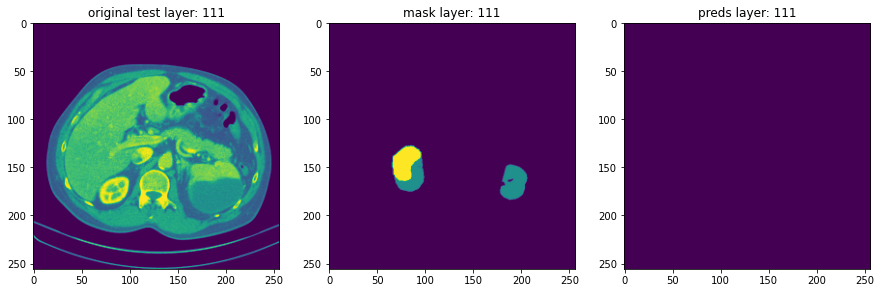

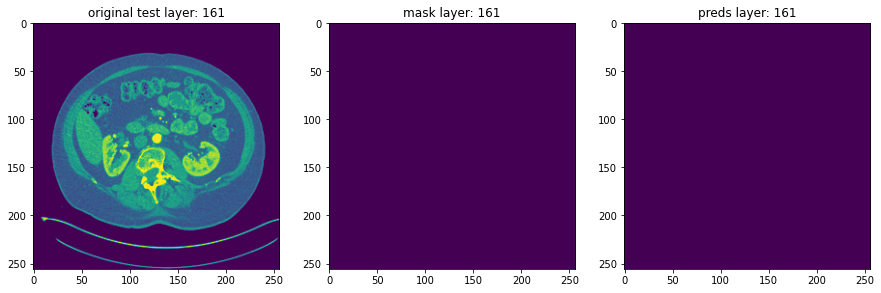

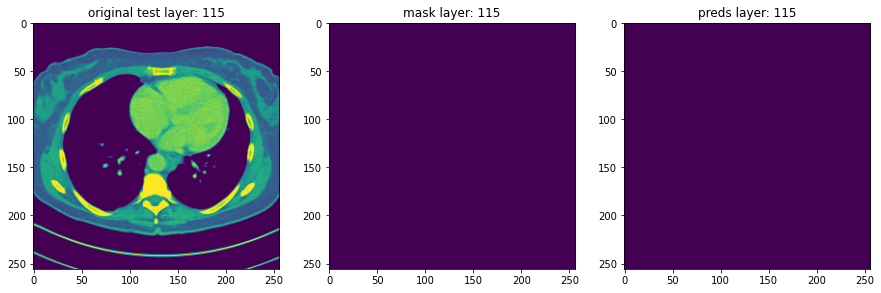

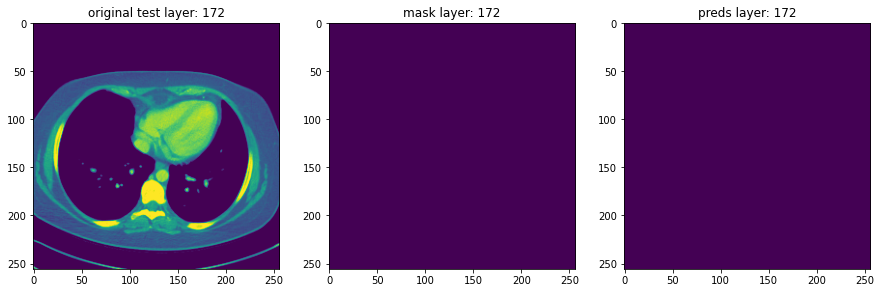

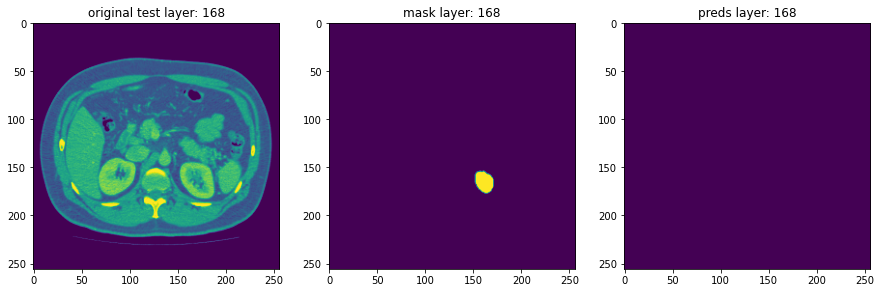

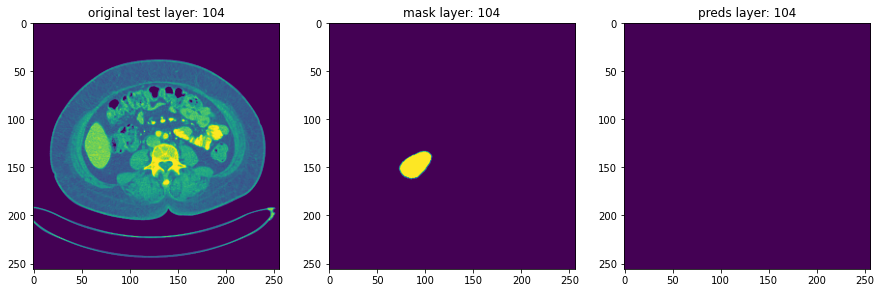

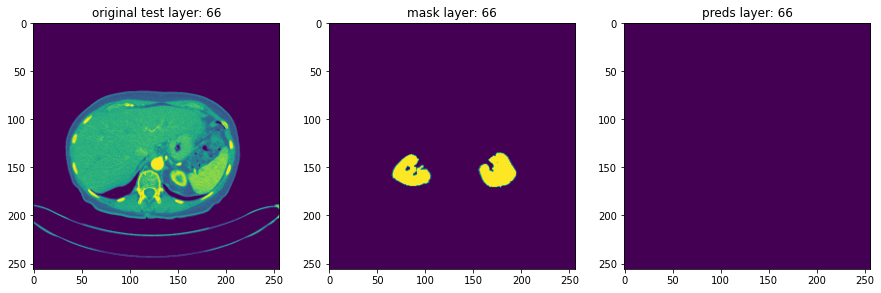

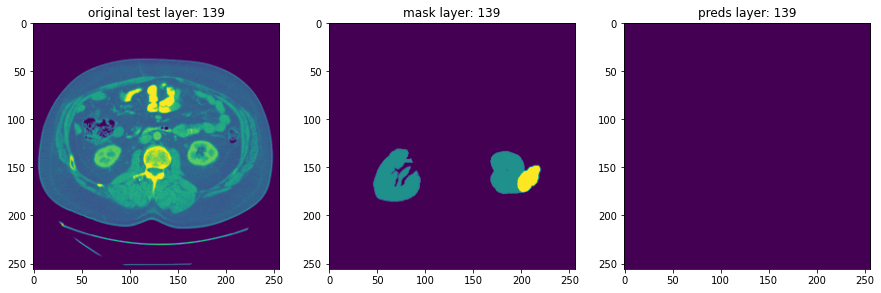

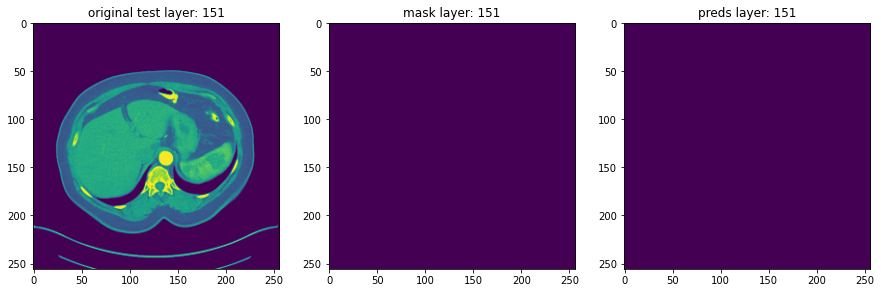

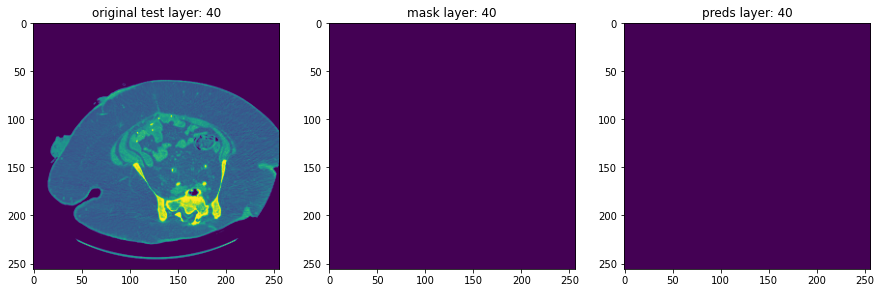

In [ ]:
#I repeat the image plotting 10 times

check_output(10,testOriginals,testMasks,preds_train_t)